In [ ]:
import jax.numpy as jnp
import jax
from fbpinns.problems import Problem, Poisson2D
 
class Poisson2D_attn(Problem):
    """
    Solves the 2D Poisson equation
        - u_xx - u_yy = f(x,y)
    on the domain [0,1] with Dirichlet boundary conditions u = 0 on ∂Ω.

    We choose f(x,y) such that the exact solution is:
        u(x,y) = sin(πx)sin(πy)
    which implies f(x,y) = 2π²sin(πx)sin(πy).
    """

    @staticmethod
    def init_params(f_coeff=2 * jnp.pi ** 2, sd=0.1, N=10000):
        # 'dims': (ud, xd) => u is scalar (ud=1) and x is 2D (xd=2)
        static_params = {
            "dims": (1, 2),
            "f_coeff": f_coeff,  # coefficient in the forcing function f(x,y)
            "sd": sd,
            'statictest': 1
        }
        return static_params, {}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):
        # --- Physics loss: sample interior points ---
        # x_batch_phys: an array of shape (n_phys, 2)
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0, (0, 0)), # u_xx
            (0, (1, 1)), # u_yy
        )

        return [[x_batch_phys, required_ujs_phys],]
    
    @staticmethod
    def constraining_fn(all_params, x_batch, u):
        sd = all_params["static"]["problem"]["sd"]
        x, y, tanh = x_batch[:,0:1], x_batch[:,1:2], jax.nn.tanh
        u = tanh((x)/sd) * tanh((1-x)/sd) * tanh((y)/sd) * tanh((1-y)/sd) * u
        return u

    @staticmethod
    def loss_fn(all_params, constraints):
        # --- Physics loss ---
        # For the physics group, the constraints have been replaced with the evaluated quantities:
        # [x_batch_phys, u_xx, u_yy]
        x_phys, u_xx, u_yy = constraints[0]
        # jax.debug.print(f'x {x_phys.shape}, uxx {u_xx.shape}, uyy {u_yy.shape}')
        # x (10000, 2) uxx (10000, 1) uyy (10000, 1)
        x, y = x_phys[:, 0:1], x_phys[:,1:2]

        # Compute the forcing term f(x,y) = 2π² sin(πx) sin(πy)
        f_coeff = all_params["static"]["problem"]["f_coeff"]
        f_val = f_coeff * jnp.sin(jnp.pi* x) * jnp.sin(jnp.pi* y)

        # The physics residual is: u_xx + u_yy + f(x,y)
        phys_residual = u_xx + u_yy + f_val
        # RBA weights
        attention = all_params["trainable"]["attention"]["alpha"]  # (N,1)
        current_i = all_params["trainable"]["problem"]["current_i"][0]

        # m1 = jnp.mean(phys_residual**2)
        # m2 = jnp.mean(((jnp.exp(-current_i*0.001)+attention)*phys_residual)**2)
        # jax.debug.print("curr_i = {i}, raw MSE = {m1:.6f}, weighted MSE = {m2:.6f}", i=current_i, m1=m1, m2=m2)
        # jax.debug.print("residual max = {a}, alpha head = {b}", a=jnp.max(jnp.abs(phys_residual)), b=attention[:5, 0])
        
        return jnp.mean(phys_residual**2) + jnp.mean(attention), phys_residual
        
        # return 

    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):
        # The exact solution is u(x,y) = sin(πx) sin(πy)
        x, y = x_batch[:, 0:1], x_batch[:,1:2]
        u = jnp.sin(jnp.pi* x) * jnp.sin(jnp.pi* y)
        return u
    

[INFO] 2025-05-12 15:14:54 - <fbpinns.constants.Constants object at 0x73a1eef088c0>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0., 0.]), 'xmax': array([1., 1.])}
problem: <class 'fbpinns.problems.Poisson2D'>
problem_init_kwargs: {}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.  , 0.25, 0.5 , 0.75, 1.  ]), array([0.  , 0.25, 0.5 , 0.75, 1.  ])], 'subdomain_ws': [array([0.725, 0.725, 0.725, 0.725, 0.725]), array([0.725, 0.725, 0.725, 0.725, 0.725])], 'unnorm': (0.0, 1.0)}
network: <class 'fbpinns.networks.StackedChebyshevKAN'>
network_init_kwargs: {'input_dim': 2, 'hidden_dim': 4, 'output_dim': 1, 'degree': 5}
n_steps: 50000
scheduler: <class 'fbpinns.schedulers.AllActiveSchedulerND'>
scheduler_kwargs: {}
ns: ((100, 100),)
n_test: (100, 100)
sampler: grid
optimiser: <function adam at 0x73a1ed7ccc20>
optimiser_kwargs: {'learning_rate': 0.0001}
seed: 

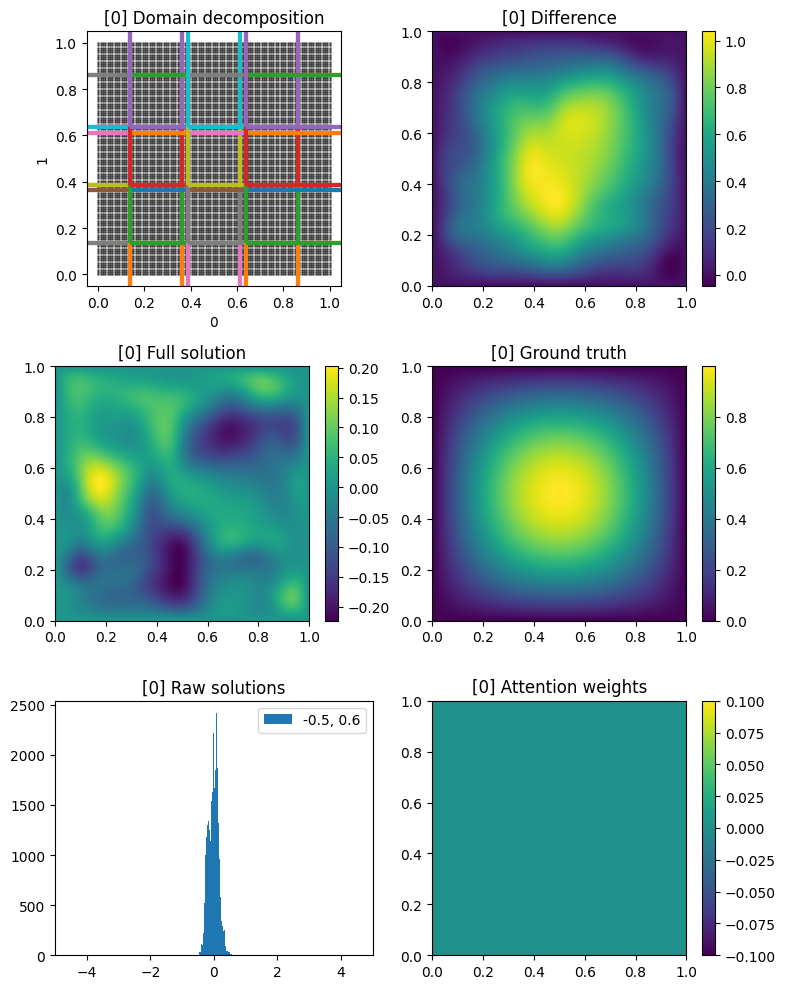

[INFO] 2025-05-12 15:15:10 - [i: 1000/50000] loss: 7.7958 rate: 108.1 elapsed: 0.00 hr test
[INFO] 2025-05-12 15:15:12 - [i: 2000/50000] loss: 0.6829 rate: 423.5 elapsed: 0.00 hr test
[INFO] 2025-05-12 15:15:14 - [i: 3000/50000] loss: 0.2676 rate: 422.7 elapsed: 0.00 hr test
[INFO] 2025-05-12 15:15:17 - [i: 4000/50000] loss: 0.1347 rate: 425.1 elapsed: 0.01 hr test
[INFO] 2025-05-12 15:15:19 - [i: 5000/50000] loss: 0.0770 rate: 425.3 elapsed: 0.01 hr test
[INFO] 2025-05-12 15:15:19 - saved arrays
True


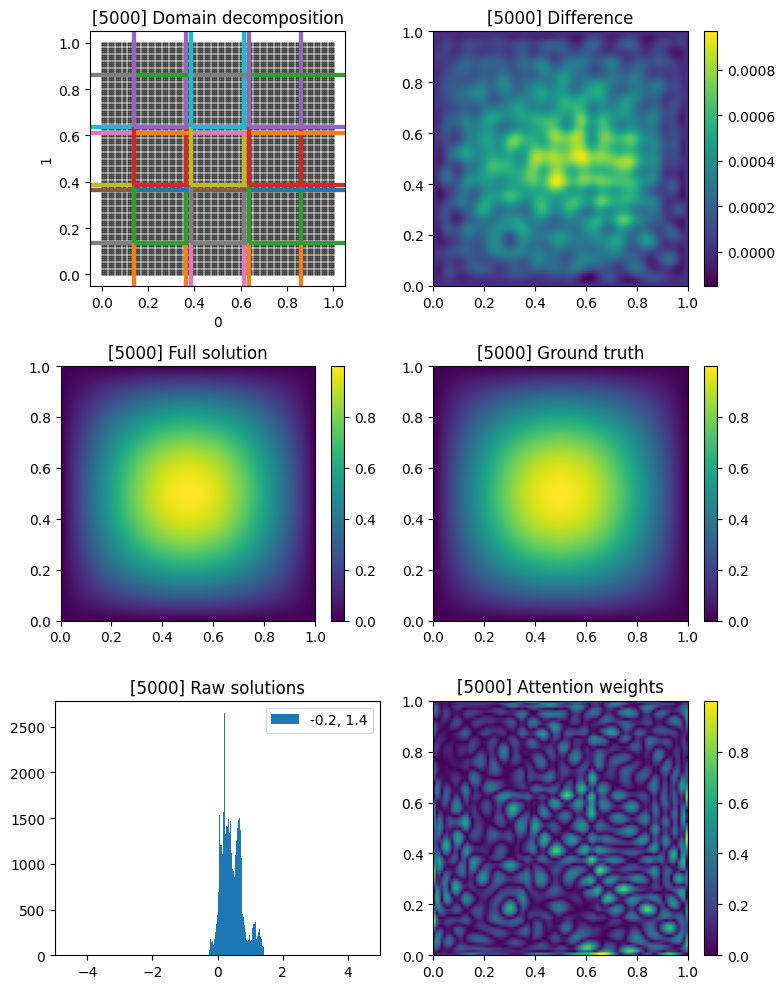

[INFO] 2025-05-12 15:15:22 - [i: 6000/50000] loss: 0.0463 rate: 422.7 elapsed: 0.01 hr test
[INFO] 2025-05-12 15:15:25 - [i: 7000/50000] loss: 0.0288 rate: 423.5 elapsed: 0.01 hr test
[INFO] 2025-05-12 15:15:27 - [i: 8000/50000] loss: 0.0187 rate: 423.7 elapsed: 0.01 hr test
[INFO] 2025-05-12 15:15:29 - [i: 9000/50000] loss: 0.0129 rate: 424.5 elapsed: 0.01 hr test
[INFO] 2025-05-12 15:15:32 - [i: 10000/50000] loss: 0.0095 rate: 424.3 elapsed: 0.01 hr test
[INFO] 2025-05-12 15:15:32 - saved arrays
True


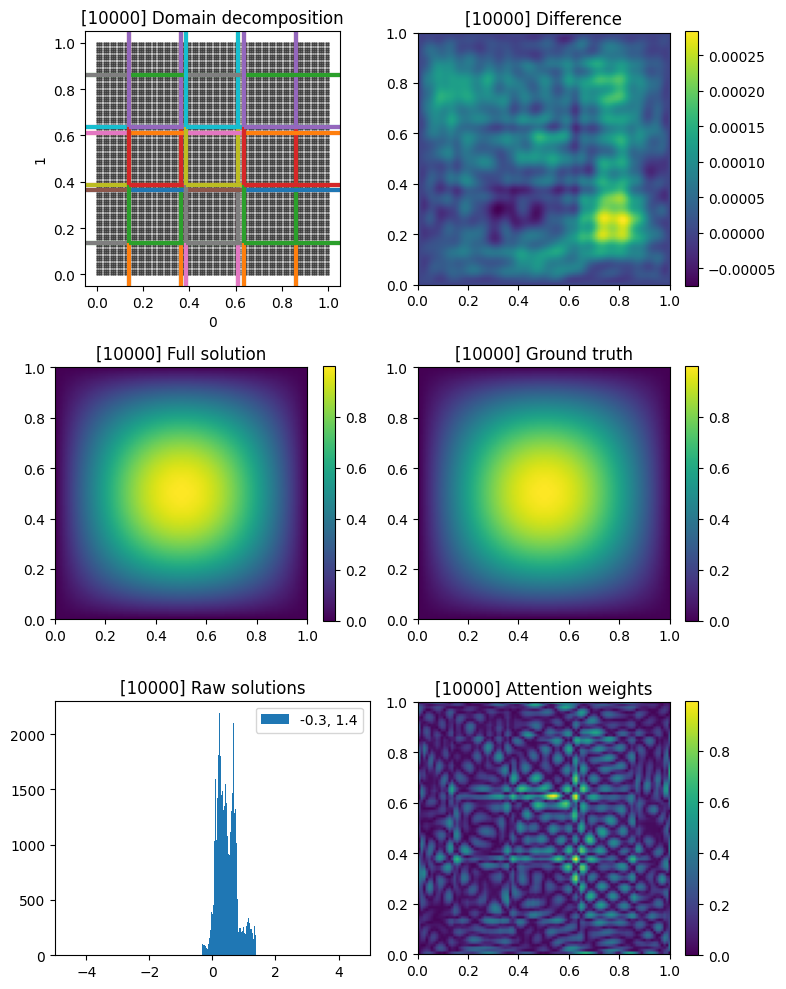

[INFO] 2025-05-12 15:15:35 - [i: 11000/50000] loss: 0.0075 rate: 425.0 elapsed: 0.01 hr test
[INFO] 2025-05-12 15:15:37 - [i: 12000/50000] loss: 0.0063 rate: 423.2 elapsed: 0.01 hr test
[INFO] 2025-05-12 15:15:40 - [i: 13000/50000] loss: 0.0051 rate: 423.9 elapsed: 0.01 hr test
[INFO] 2025-05-12 15:15:42 - [i: 14000/50000] loss: 0.0045 rate: 422.4 elapsed: 0.01 hr test
[INFO] 2025-05-12 15:15:45 - [i: 15000/50000] loss: 0.0039 rate: 423.5 elapsed: 0.01 hr test
[INFO] 2025-05-12 15:15:45 - saved arrays
True


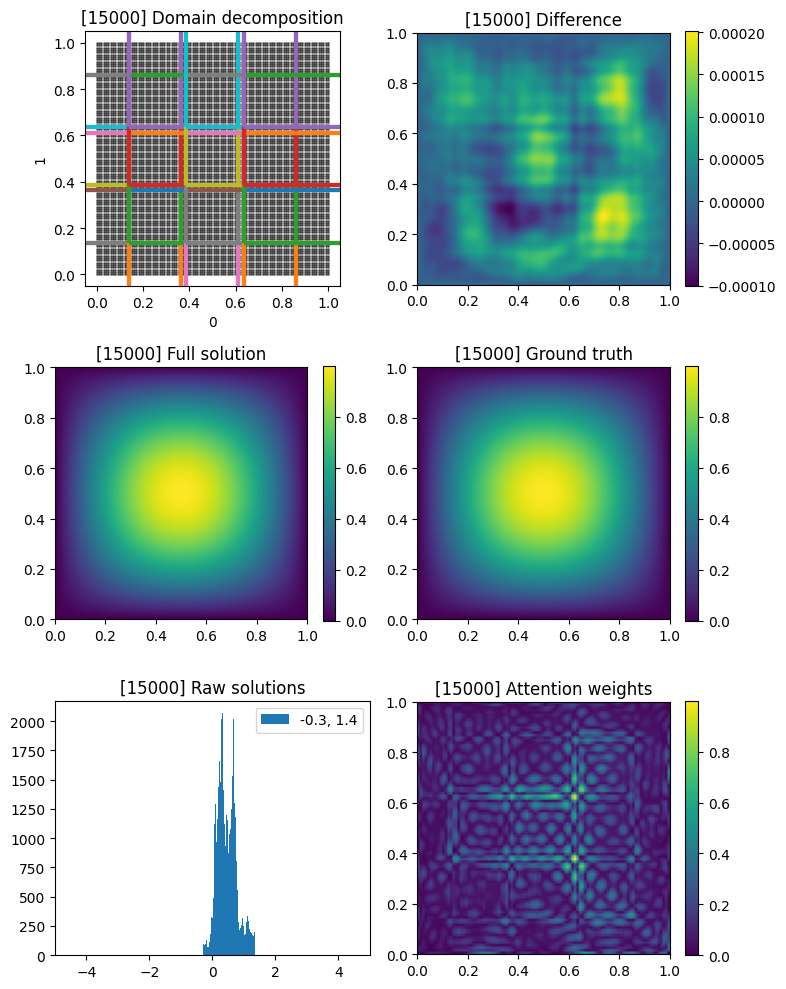

[INFO] 2025-05-12 15:15:48 - [i: 16000/50000] loss: 0.0036 rate: 424.5 elapsed: 0.01 hr test
[INFO] 2025-05-12 15:15:50 - [i: 17000/50000] loss: 0.0032 rate: 423.5 elapsed: 0.01 hr test
[INFO] 2025-05-12 15:15:53 - [i: 18000/50000] loss: 0.0032 rate: 422.4 elapsed: 0.02 hr test
[INFO] 2025-05-12 15:15:55 - [i: 19000/50000] loss: 0.0029 rate: 423.2 elapsed: 0.02 hr test
[INFO] 2025-05-12 15:15:58 - [i: 20000/50000] loss: 0.0027 rate: 422.9 elapsed: 0.02 hr test
[INFO] 2025-05-12 15:15:58 - saved arrays
True


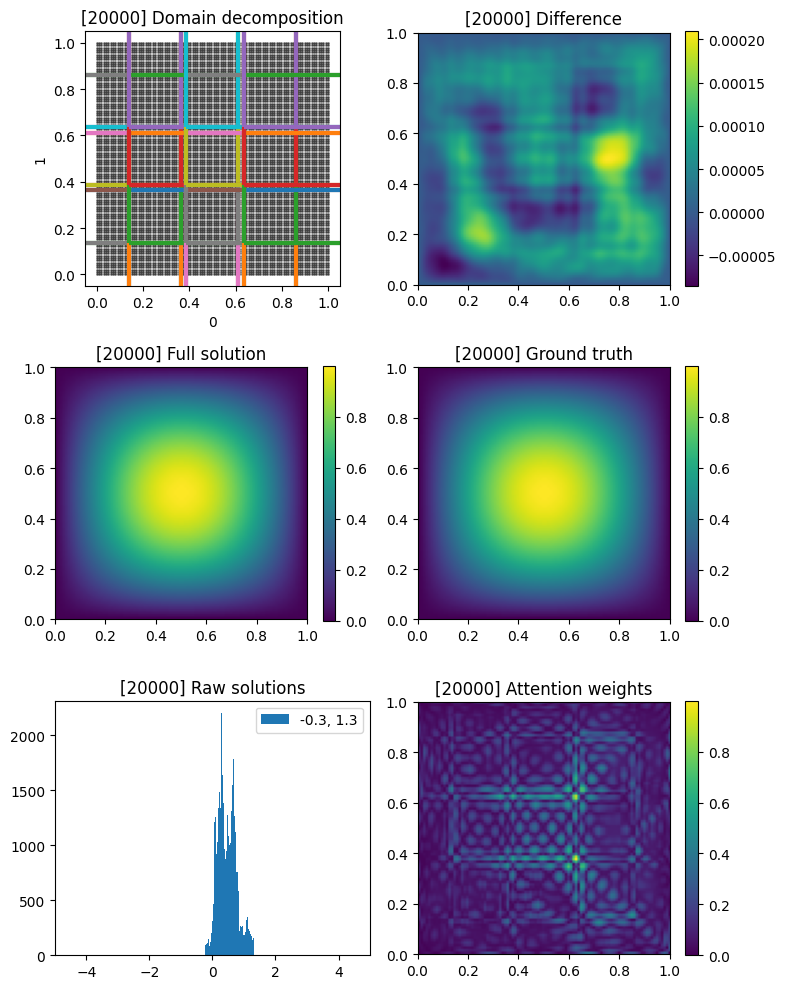

[INFO] 2025-05-12 15:16:01 - [i: 21000/50000] loss: 0.0026 rate: 422.3 elapsed: 0.02 hr test
[INFO] 2025-05-12 15:16:03 - [i: 22000/50000] loss: 0.0024 rate: 424.6 elapsed: 0.02 hr test
[INFO] 2025-05-12 15:16:06 - [i: 23000/50000] loss: 0.0026 rate: 426.0 elapsed: 0.02 hr test
[INFO] 2025-05-12 15:16:08 - [i: 24000/50000] loss: 0.0023 rate: 423.5 elapsed: 0.02 hr test
[INFO] 2025-05-12 15:16:10 - [i: 25000/50000] loss: 0.0022 rate: 422.2 elapsed: 0.02 hr test
[INFO] 2025-05-12 15:16:11 - saved arrays
True


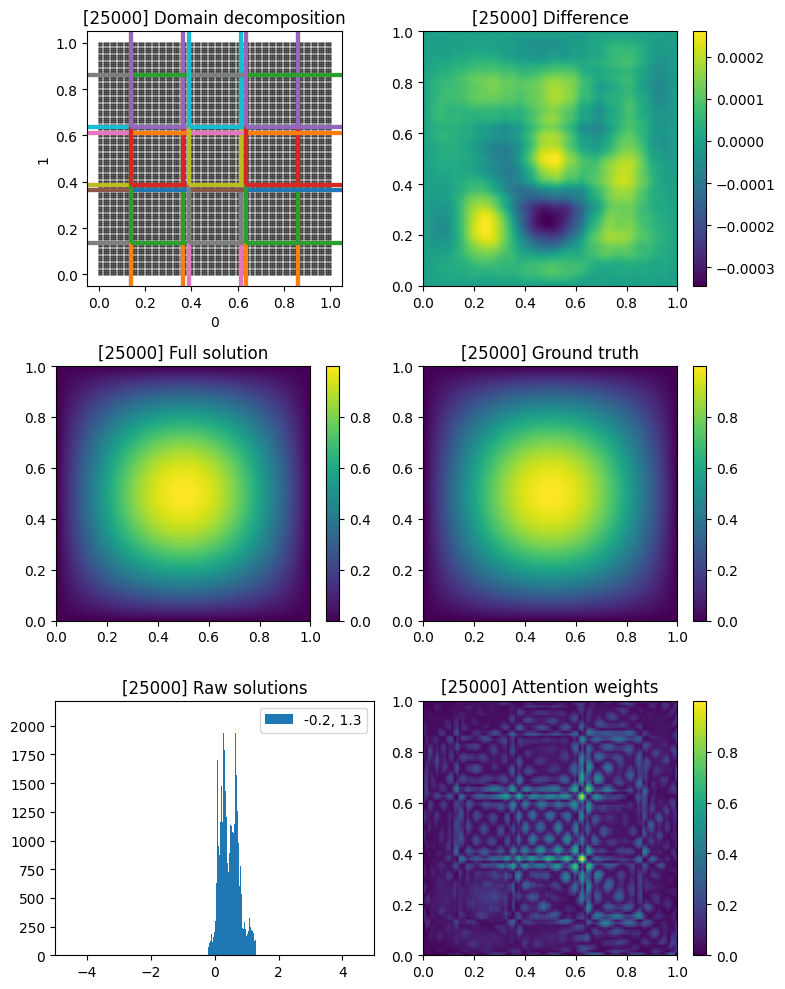

[INFO] 2025-05-12 15:16:14 - [i: 26000/50000] loss: 0.0020 rate: 423.7 elapsed: 0.02 hr test
[INFO] 2025-05-12 15:16:16 - [i: 27000/50000] loss: 0.0020 rate: 423.6 elapsed: 0.02 hr test
[INFO] 2025-05-12 15:16:18 - [i: 28000/50000] loss: 0.0019 rate: 424.1 elapsed: 0.02 hr test


KeyboardInterrupt: 

In [2]:
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.problems import BurgersEquation2D
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import ChebyshevKAN, FCN, ChebyshevAdaptiveKAN, HermiteKAN, StackedChebyshevKAN
from fbpinns.schedulers import LineSchedulerRectangularND, PointSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer, PINNTrainer
from fbpinns.attention import RBAttention

subdomain_xs=[np.linspace(0,1,5), np.linspace(0,1,5)]
c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs = dict(
        xmin=np.array([0.,0.]),
        xmax=np.array([1.,1.])
        ),
    problem=Poisson2D,
    problem_init_kwargs = dict(),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 2.9),
        unnorm=(0., 1.),
    ),
    # network=FCN,
    # network_init_kwargs = dict(
    #     layer_sizes = (2, 10, 1),
    # ),
    optimiser_kwargs = dict(
        learning_rate=0.0001
    ),
    network=StackedChebyshevKAN,
    network_init_kwargs=dict(
        input_dim=2,
        hidden_dim=4,
        output_dim=1,
        degree=5,
        # kind=1
    ),
    # network=HermiteKAN,
    # network_init_kwargs=dict(
    #     input_dim=2,
    #     output_dim=1,
    #     degree=10,
    # ),
    # optimiser_kwargs = dict(
    #     learning_rate=0.000001
    # ),
    # scheduler = LineSchedulerRectangularND,
    # scheduler_kwargs = dict(
    #     point=[0.], iaxis=0,
    # ),
    # scheduler = PointSchedulerRectangularND,
    # scheduler_kwargs = dict(
    #     point=[0.5, 0.5],\
    # ),
    # First element: interior sampling shape for the physics loss (here 200 x 200 points)
    # Second element: boundary sampling shapes; for 2D, we need 4 tuples (one for each boundary)
    ns=((100, 100),),
    # n_test provides the test sampling shape for the interior (here also 200 x 200)
    n_test=(100, 100),
    n_steps=50000,
    clear_output=False,
    attention_tracker=RBAttention,
    attention_tracking_kwargs=dict(
        eta_lr = 1e-2,
        gamma_decay = 0.99,
        out_dim=1,
        N=10000
        ),
)

run = FBPINNTrainer(c)
# run = PINNTrainer(c)
all_params = run.train()

In [ ]:
all_params

({'static': {'domain': {'xd': 2,
    'xmin': Array([0., 0.], dtype=float32),
    'xmax': Array([1., 1.], dtype=float32)},
   'problem': {'dims': (1, 2),
    'f_coeff': 19.739208802178716,
    'sd': 0.1,
    'statictest': 1},
   'decomposition': {'m': 25,
    'xd': 2,
    'subdomain': {'params': [Array([[-0.3625, -0.3625],
             [-0.3625, -0.1125],
             [-0.3625,  0.1375],
             [-0.3625,  0.3875],
             [-0.3625,  0.6375],
             [-0.1125, -0.3625],
             [-0.1125, -0.1125],
             [-0.1125,  0.1375],
             [-0.1125,  0.3875],
             [-0.1125,  0.6375],
             [ 0.1375, -0.3625],
             [ 0.1375, -0.1125],
             [ 0.1375,  0.1375],
             [ 0.1375,  0.3875],
             [ 0.1375,  0.6375],
             [ 0.3875, -0.3625],
             [ 0.3875, -0.1125],
             [ 0.3875,  0.1375],
             [ 0.3875,  0.3875],
             [ 0.3875,  0.6375],
             [ 0.6375, -0.3625],
             [ 0